In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from io import open
import glob
import os, sys
import unicodedata
import string
import time
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from random import randint
from torch.autograd import Variable
import numpy as np
from numpy.random import shuffle

In [3]:
from common import *

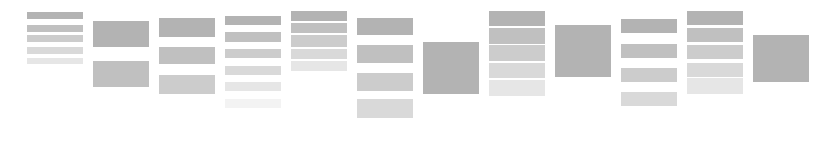

In [4]:
from datasets.hanoi.list1d import *
raster_list(get_samples(12), limit=12, width=32)

# NOTE: overall document embedding h
# NOTE: coordinator distributes h among children
# NOTE: repeat-recurse

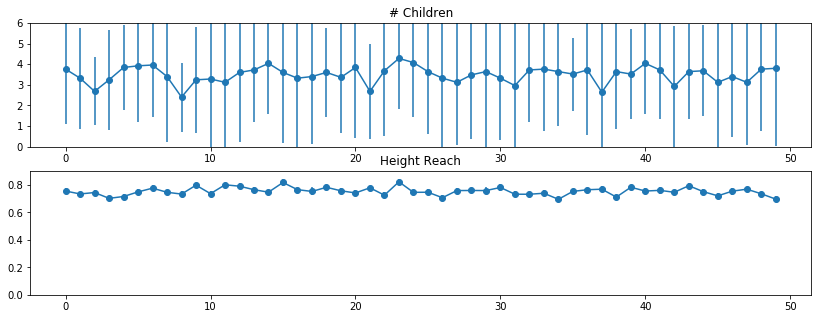

In [5]:
from datasets.hanoi.list1d import *

hist = [get_samples(25) for ii in range(50)]
plot_distrib(hist)

In [6]:
from models.list1d import *

In [7]:
LR = 1e-5
BSIZE = 64
bhalf = BSIZE // 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
real_labels = Variable(torch.ones(bhalf, 1), requires_grad=False).to(device)
fake_labels = Variable(torch.zeros(bhalf, 1), requires_grad=False).to(device)
device

device(type='cuda', index=0)

In [8]:
HSIZE=2
ZSIZE=20
REZ=6

spawn = SpawnNet(hsize=HSIZE, zsize=ZSIZE, rez=REZ).to(device)
discrim = DiscrimNet(hsize=HSIZE, rez=REZ).to(device)

gen_opt = optim.Adam([
    { 'params': spawn.parameters() },
], lr=LR)

discrim_opt = optim.Adam([
    { 'params': discrim.parameters() },
], lr=LR)

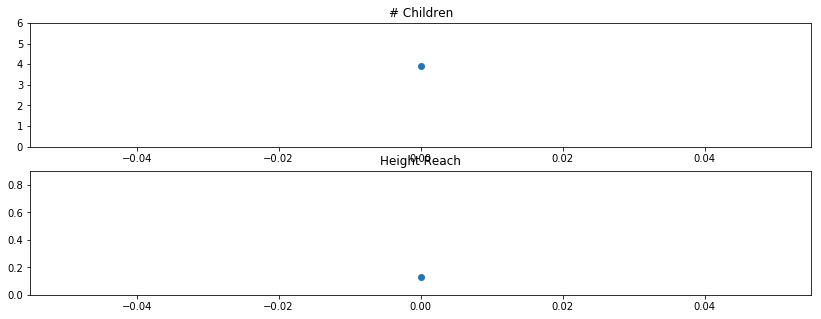

In [9]:
def sample_fakes():
    fake_samples = []
    bases = get_samples(100, baseonly=True)
    for stack in bases:
        zvar = spawn.init_noise(size=ZSIZE).to(device)
        hparent = stack[0].to(device)
        hchildren = spawn(hparent, zvar, concat=True)
        stack[1] = [hchildren.detach().cpu()[0, rii, :] for rii in range(REZ)]
        fake_samples.append(stack)
    return fake_samples

history=[sample_fakes()]
plot_distrib(history)

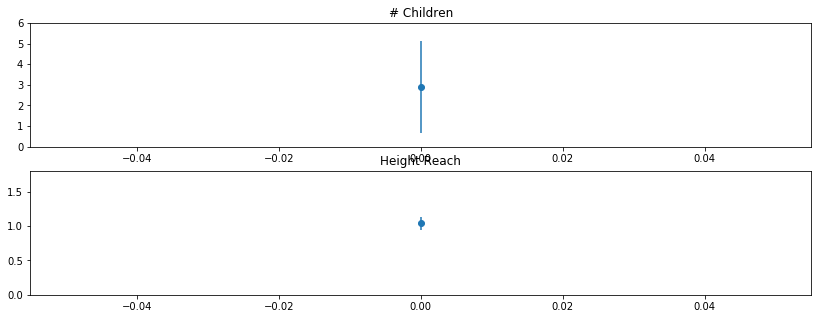

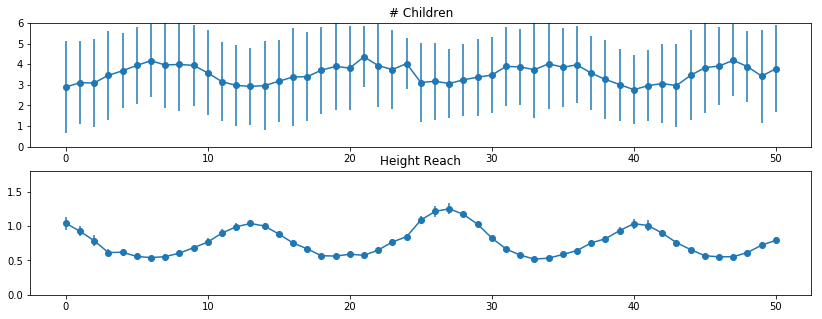

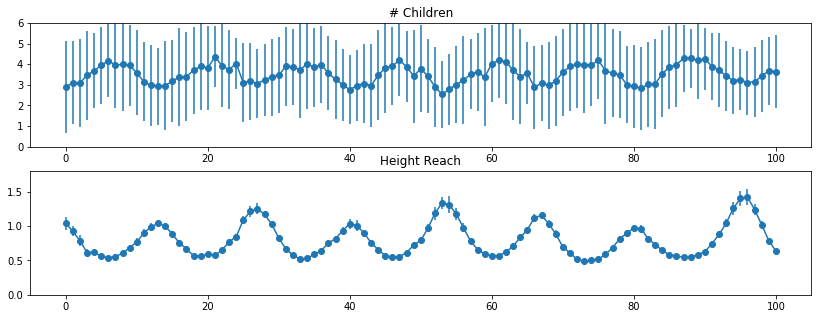

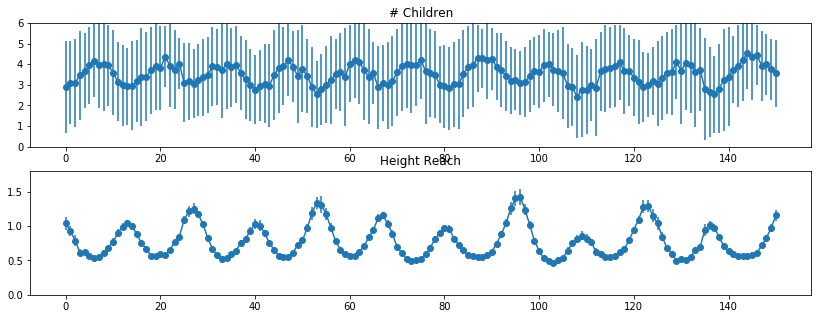

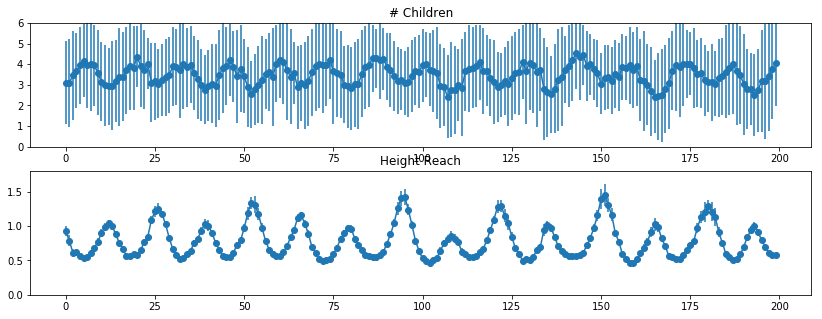

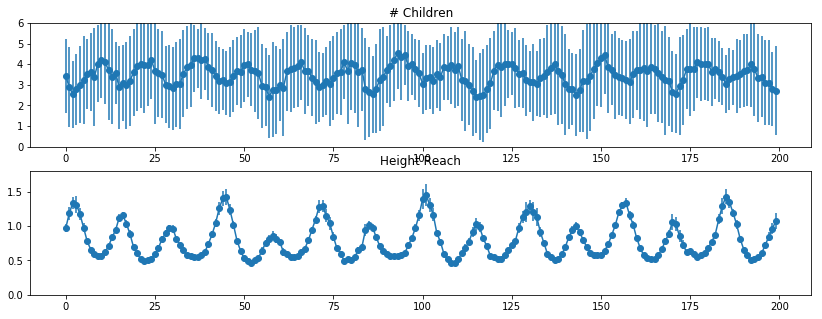

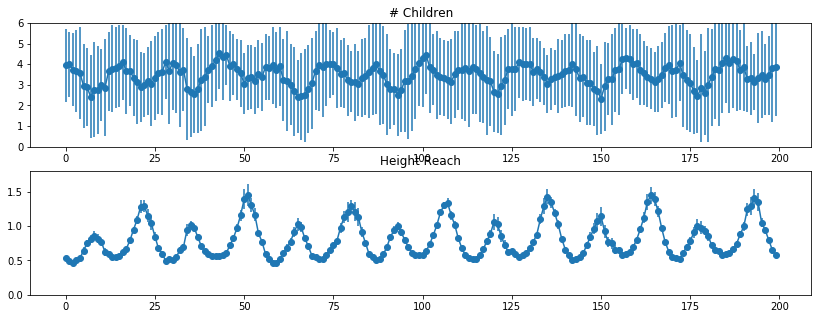

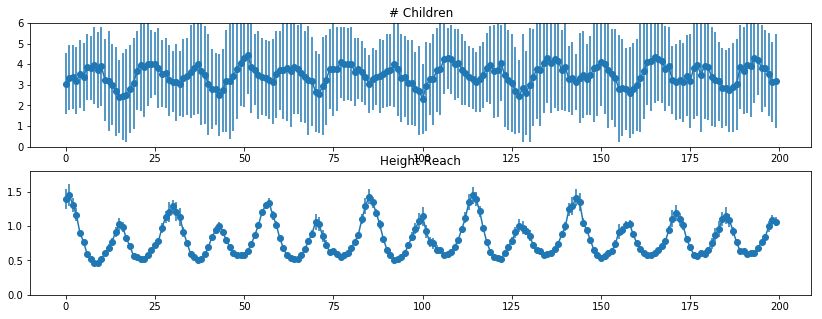

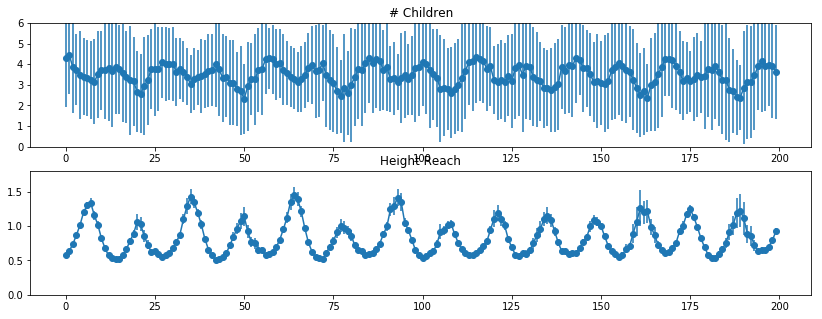

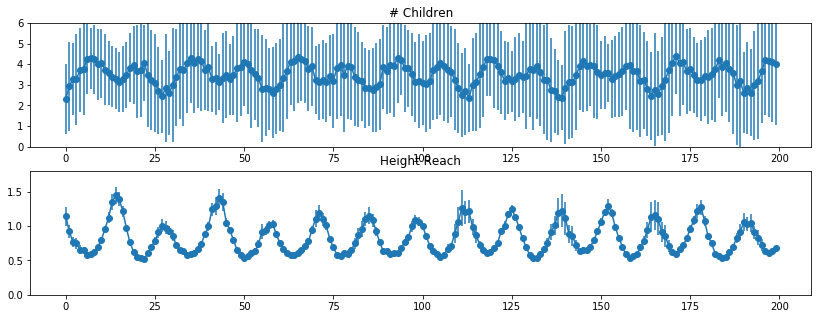

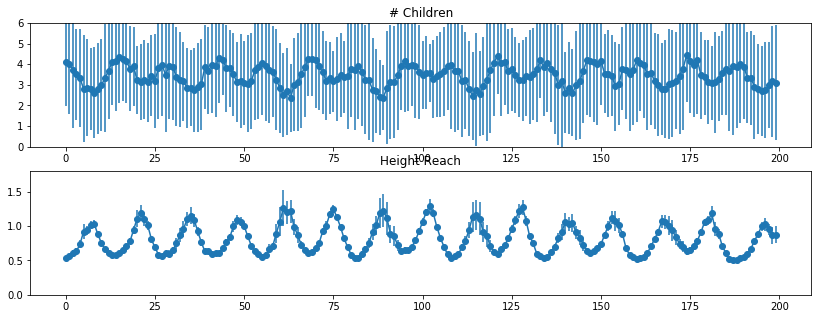

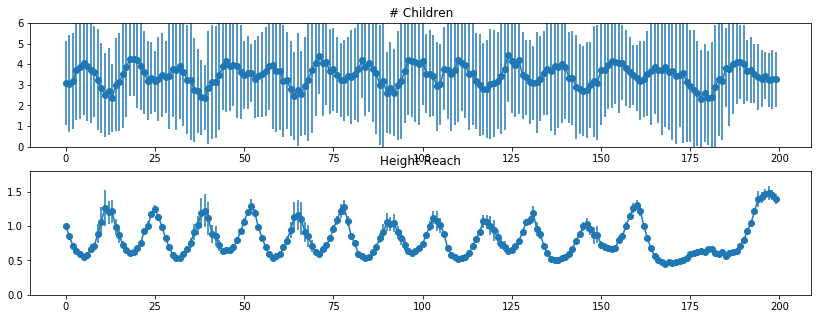

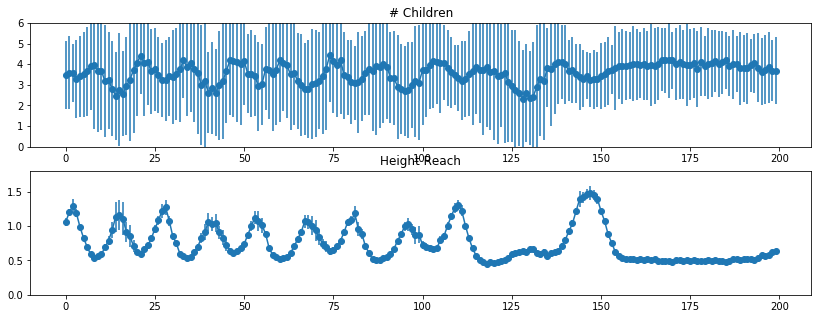

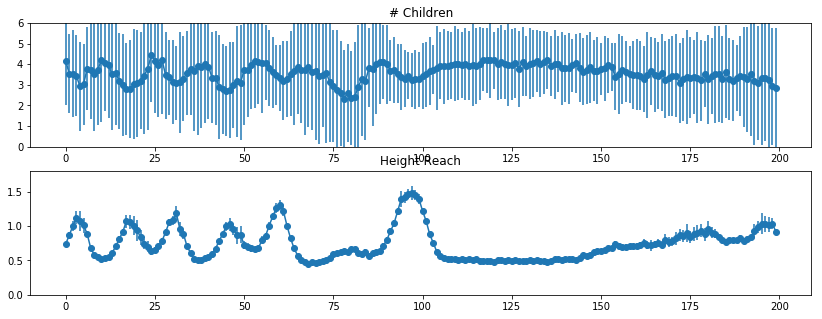

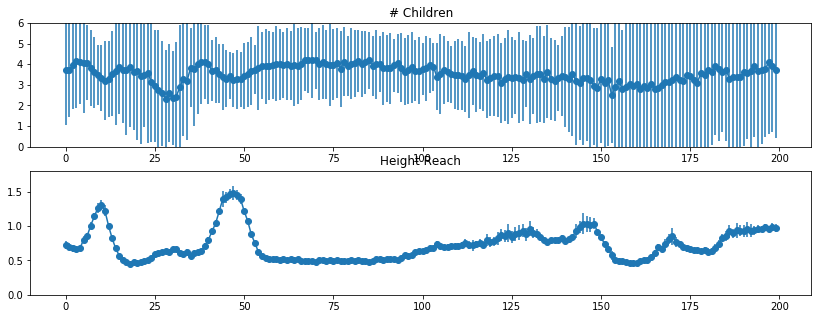

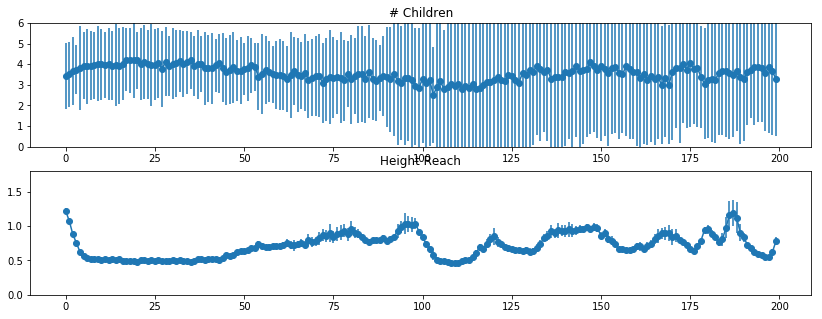

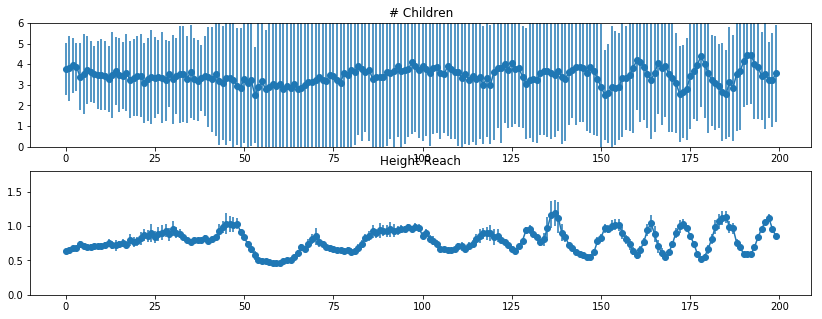

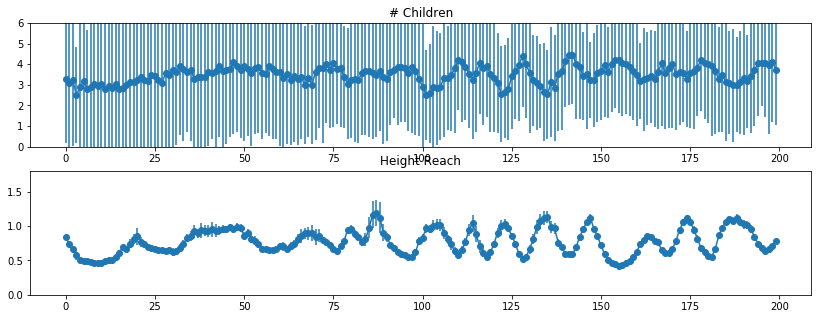

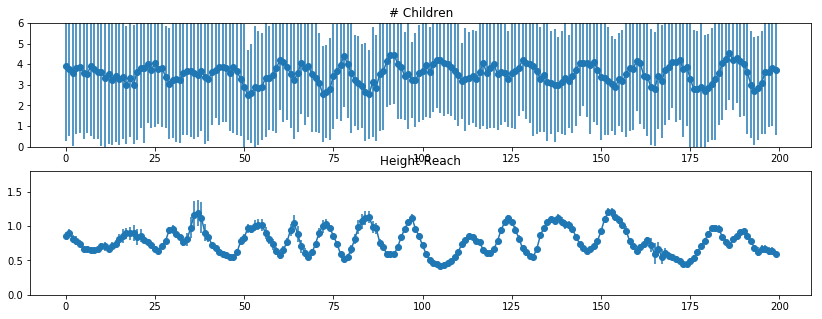

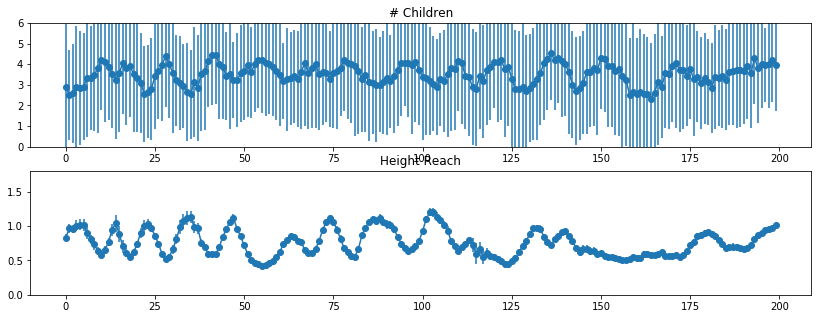

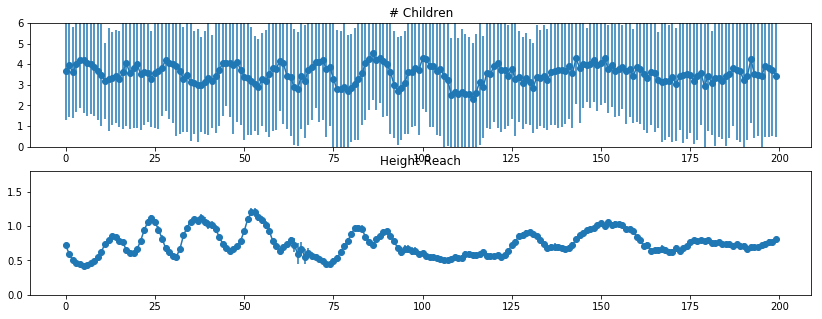

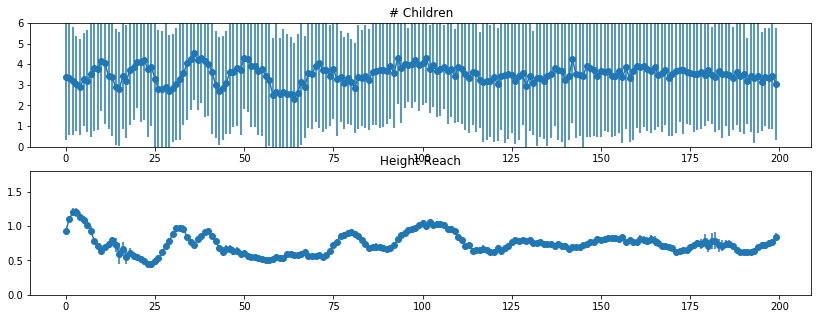

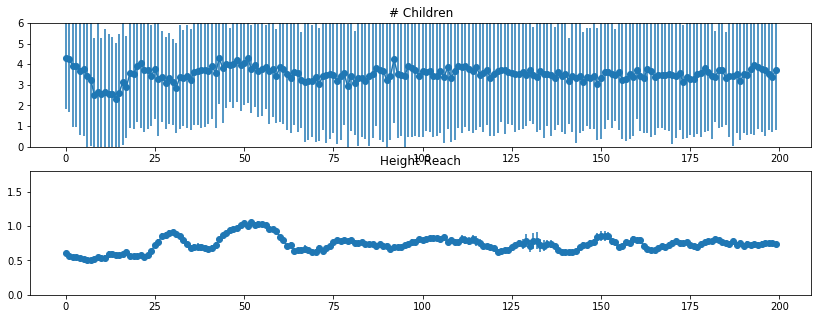

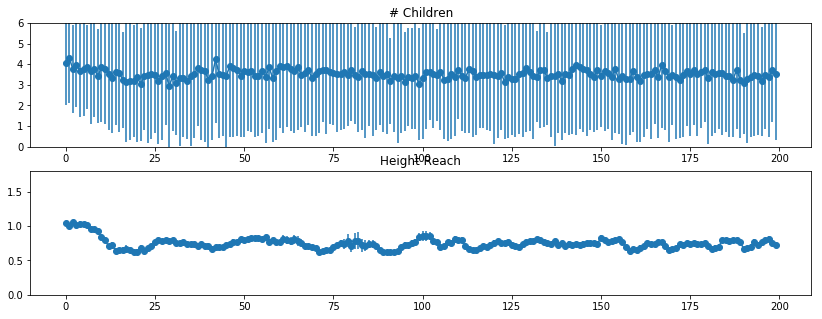

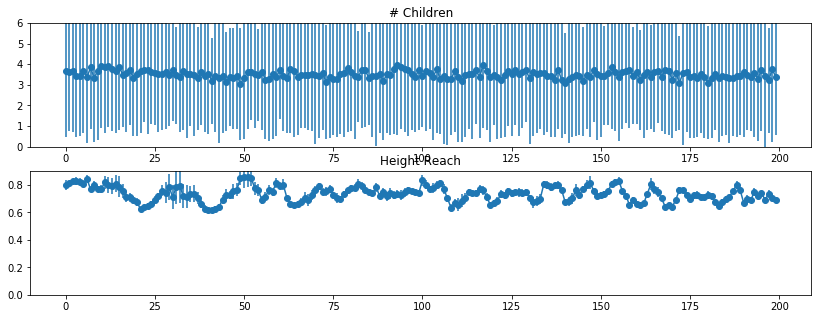

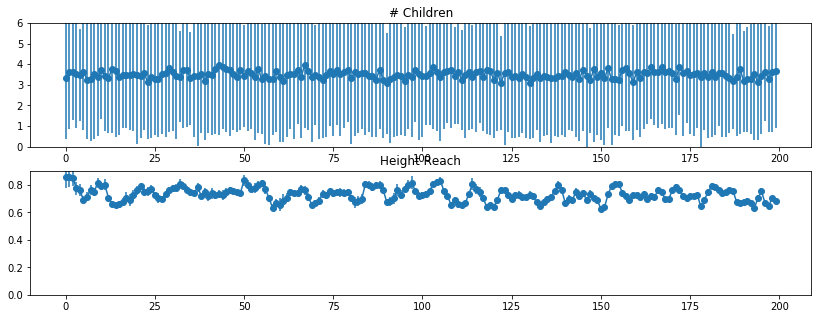

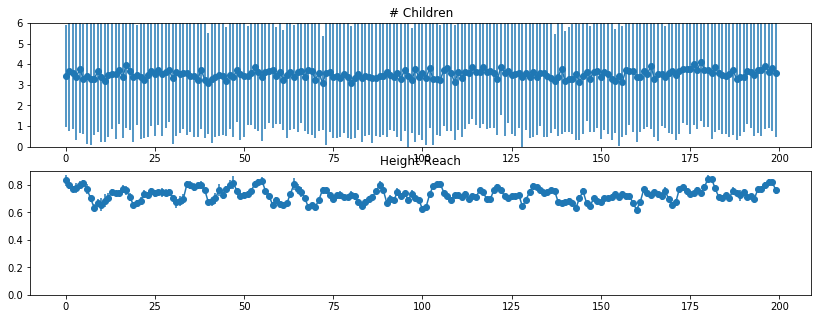

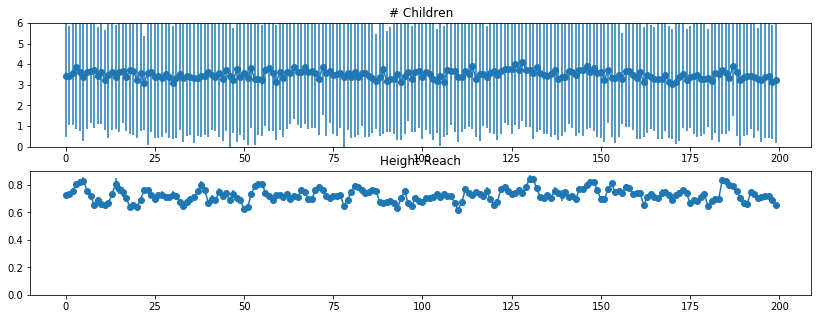

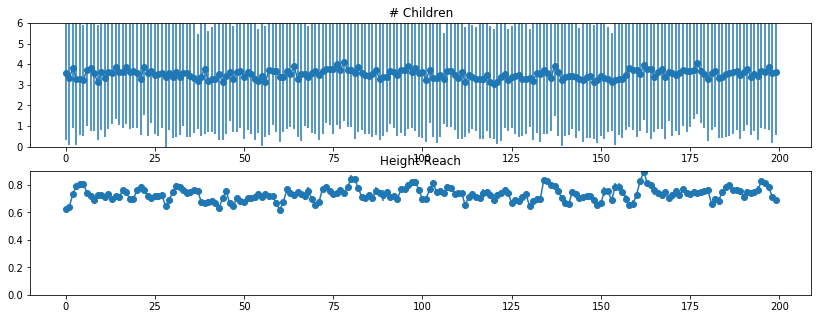

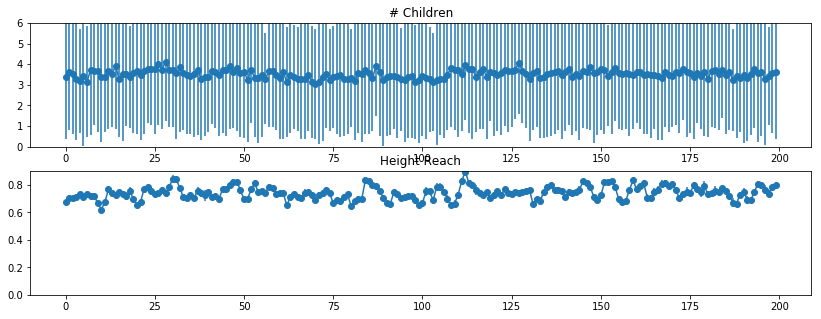

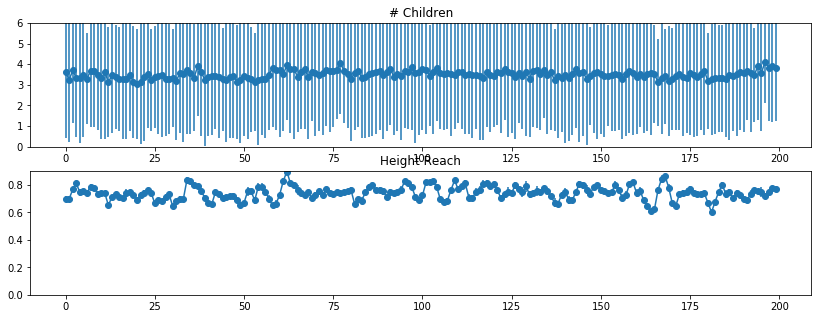

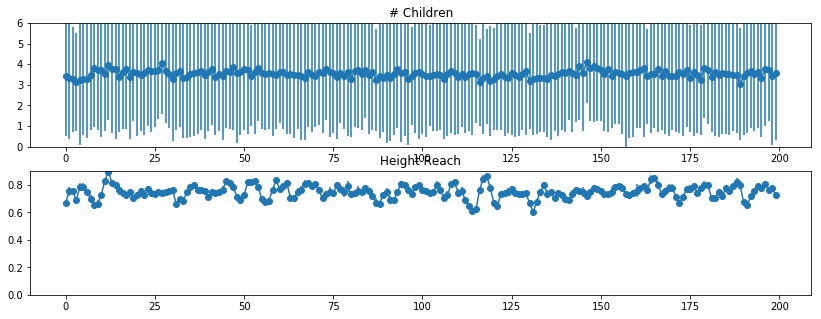

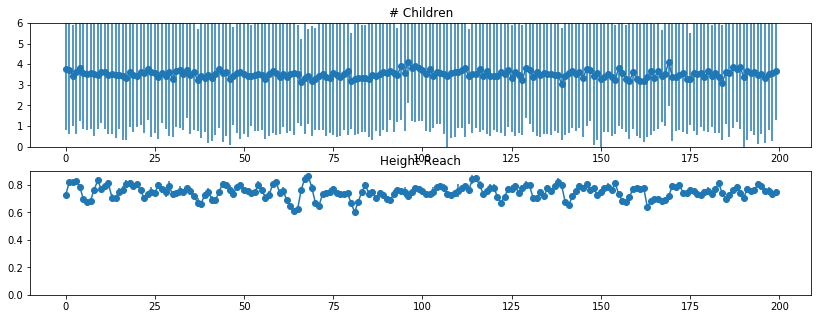

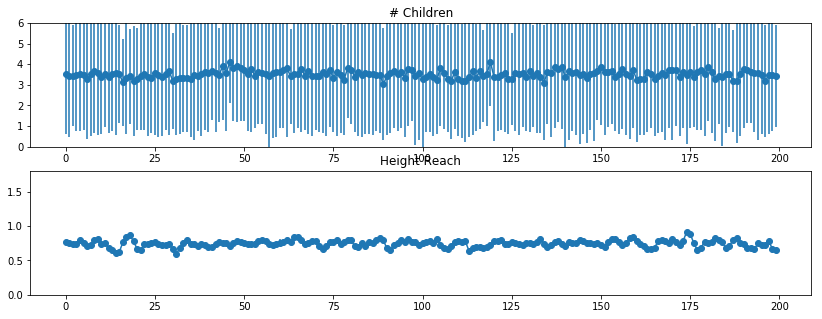

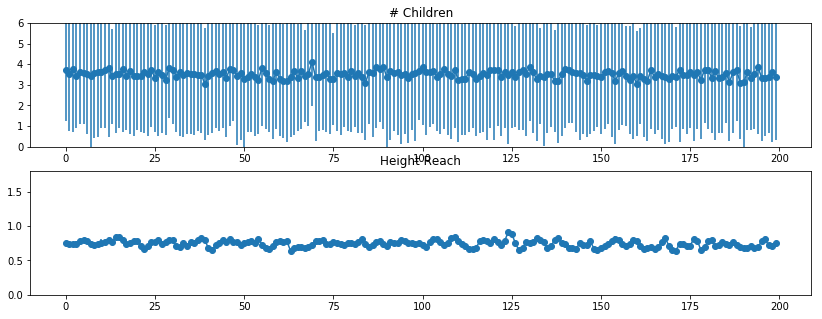

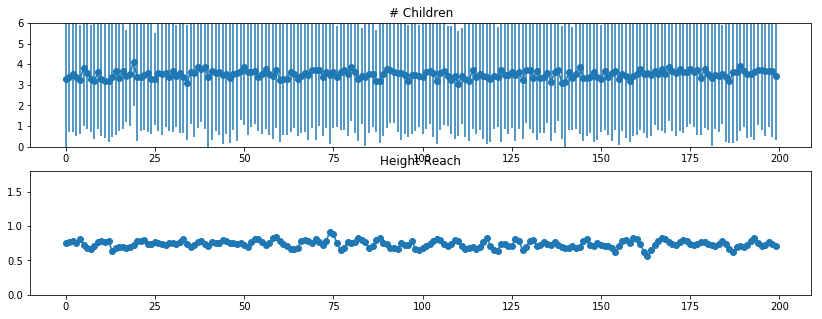

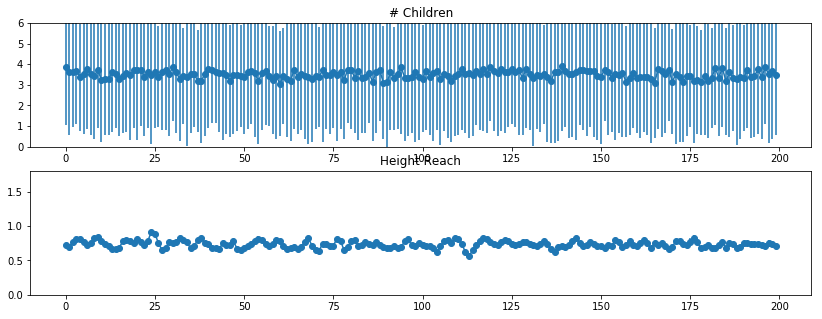

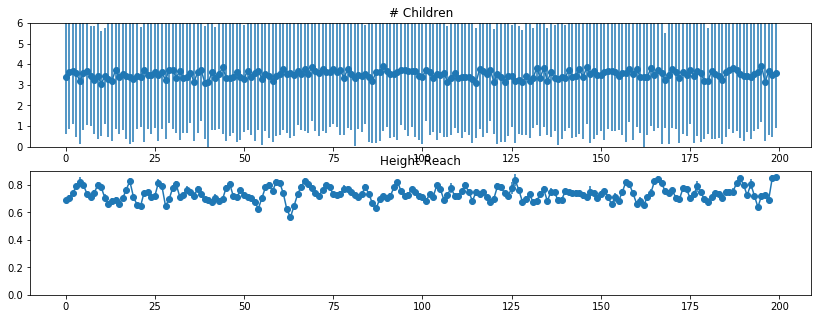

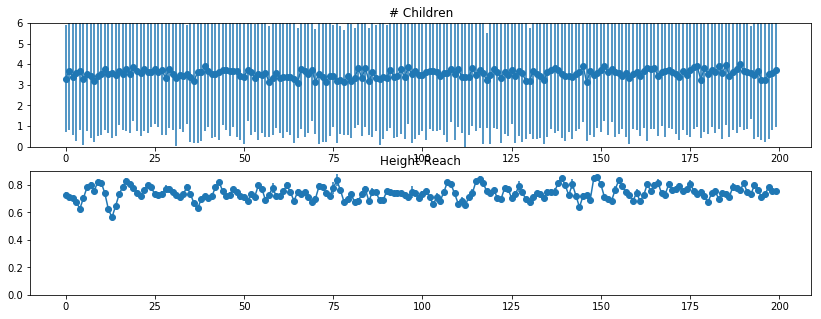

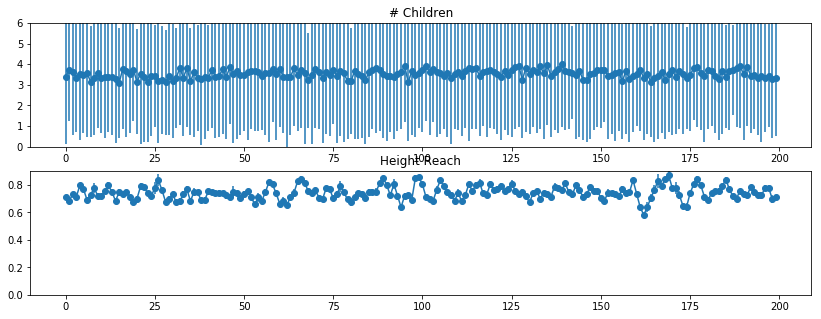

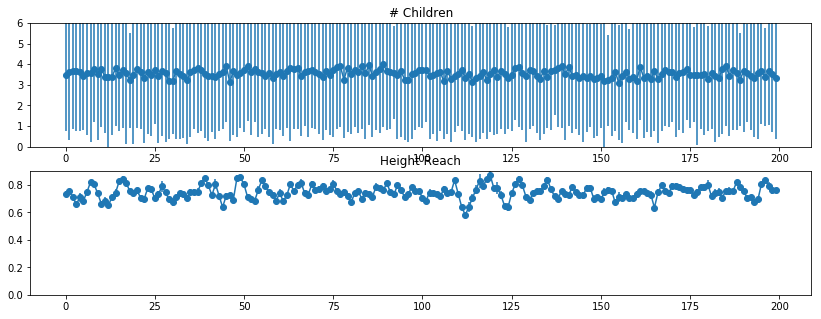

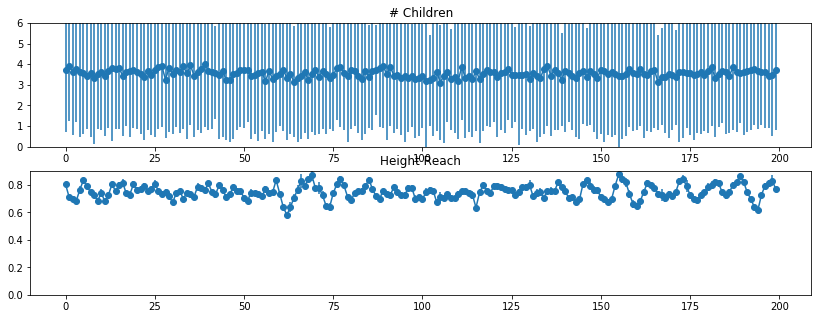

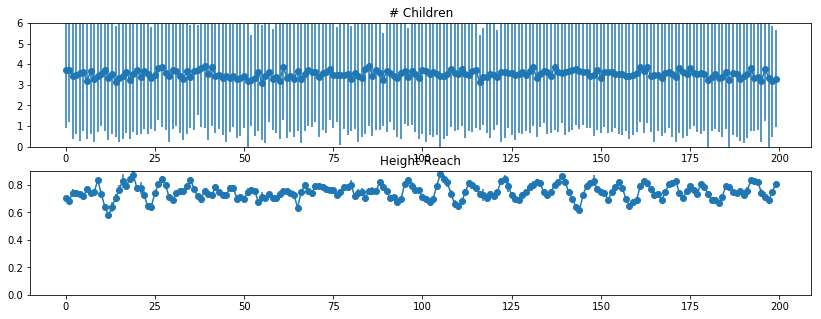

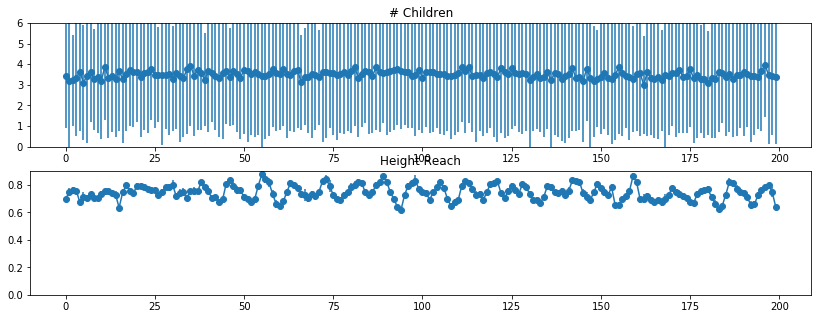

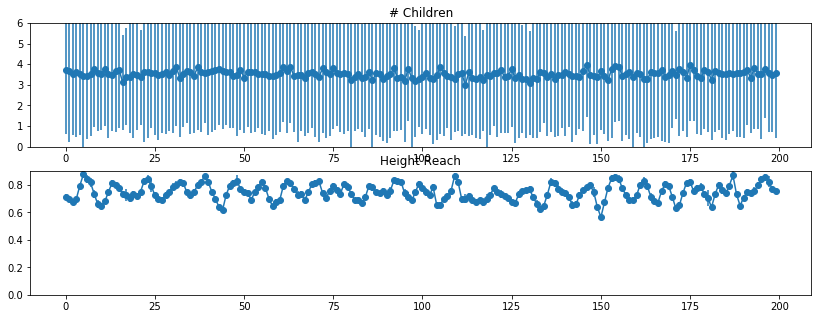

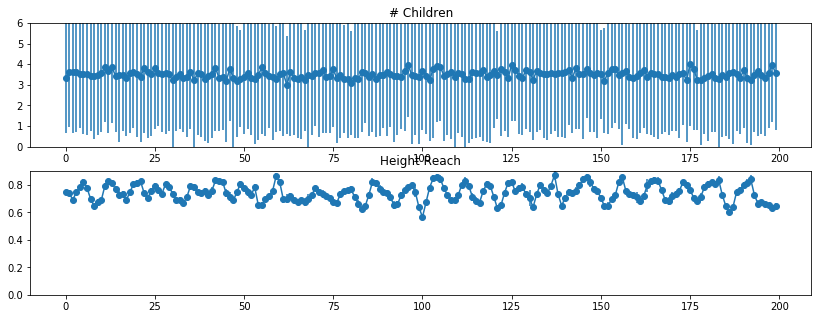

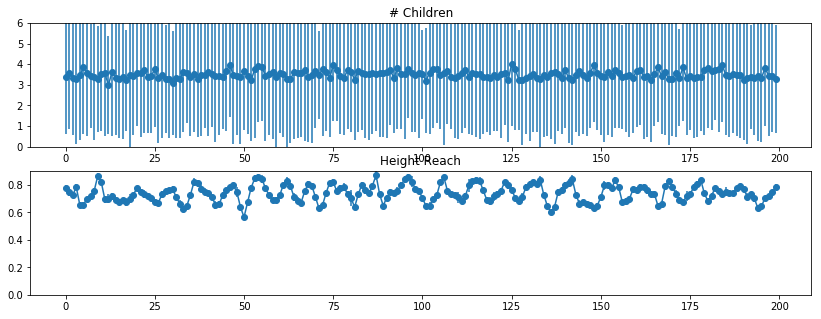

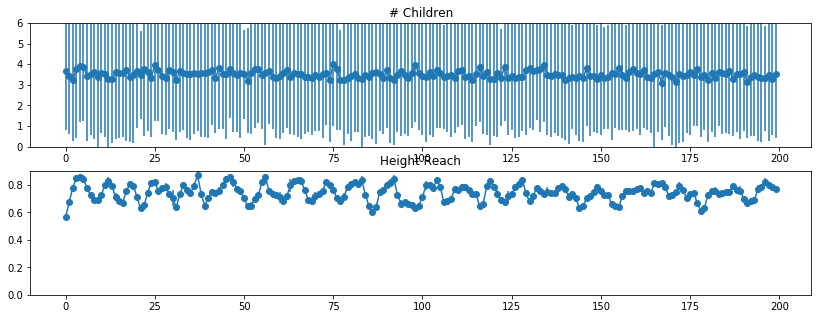

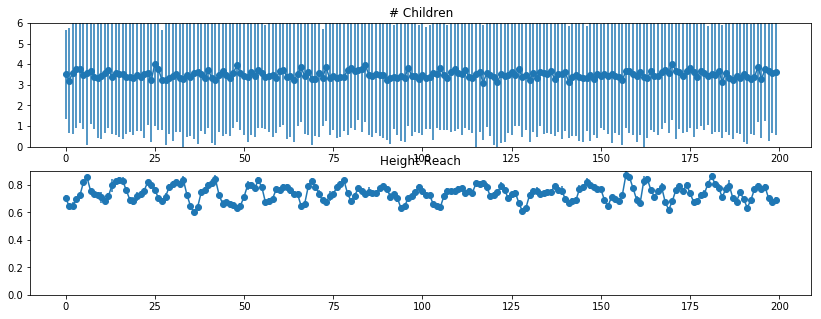

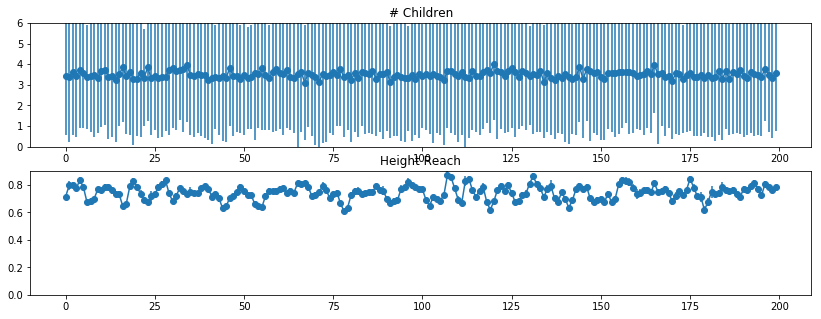

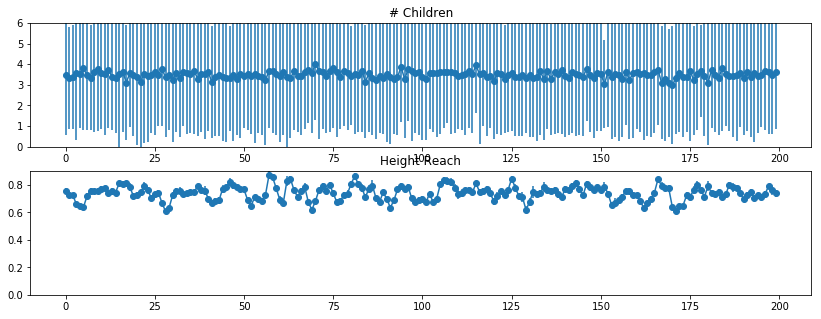

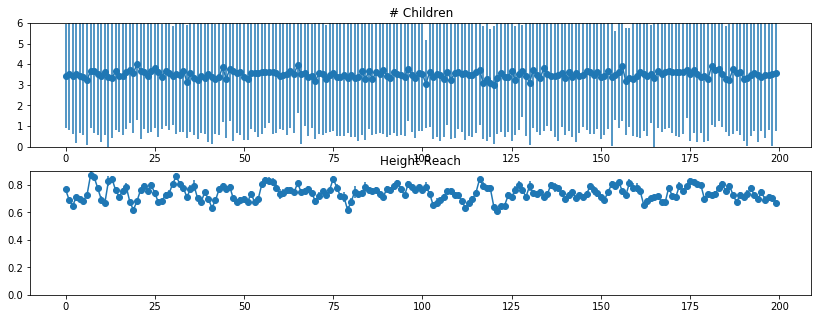

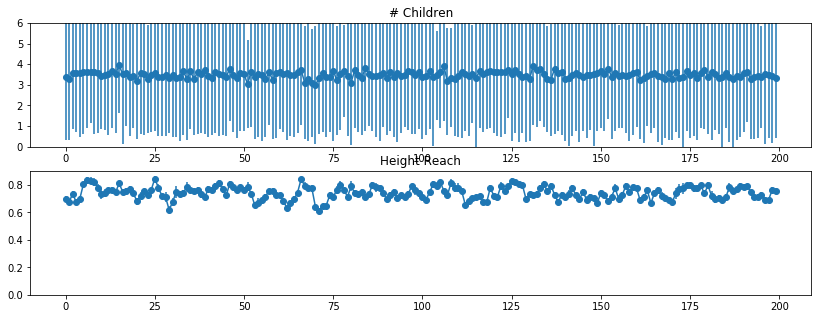

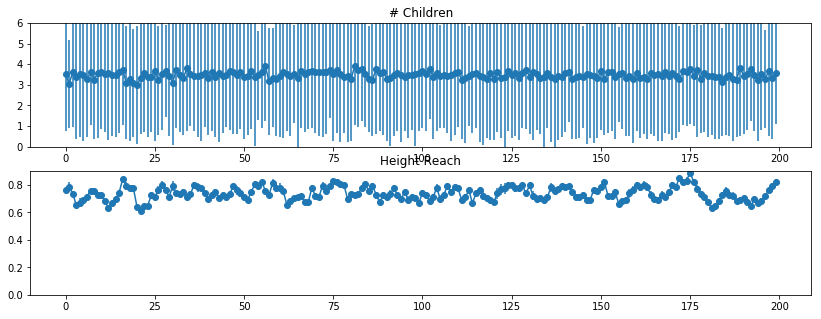

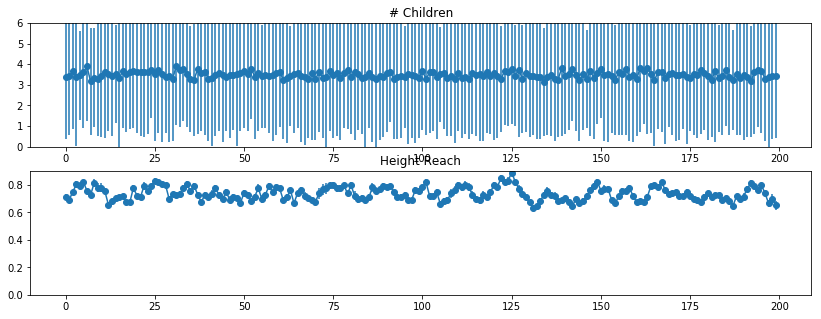

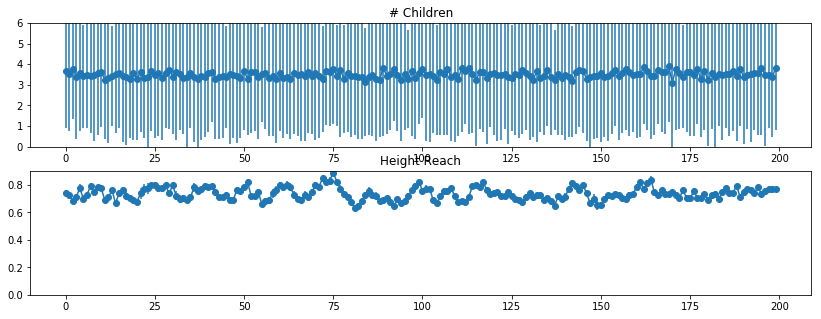

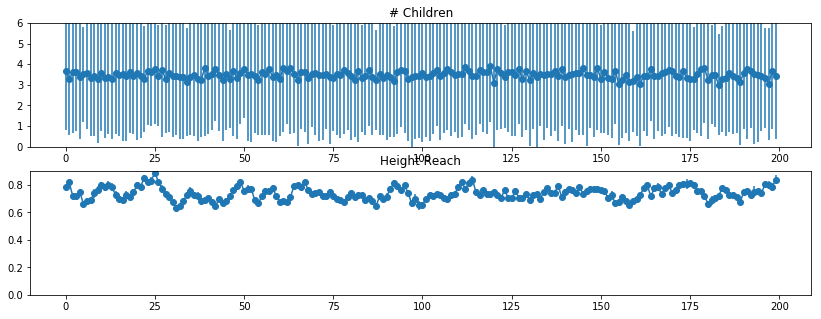

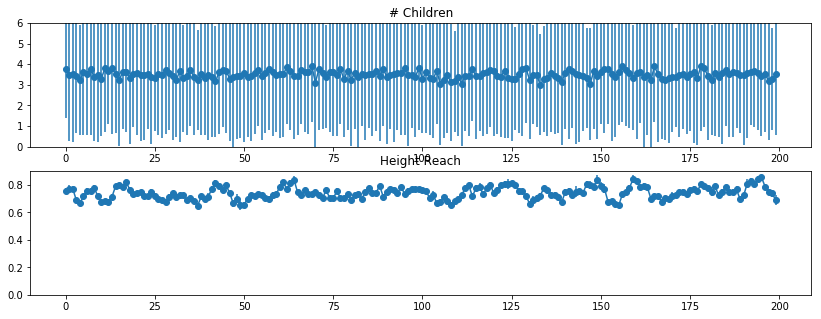

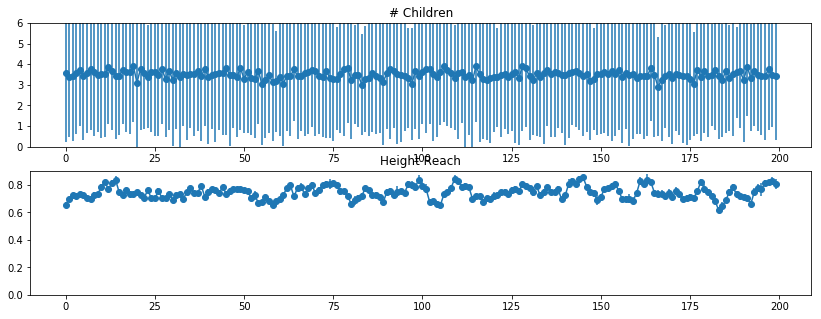

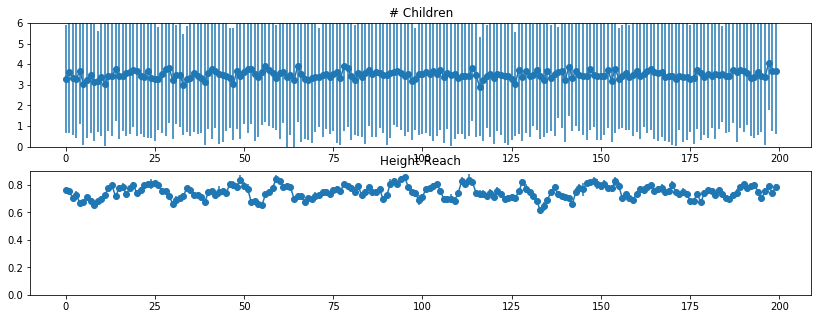

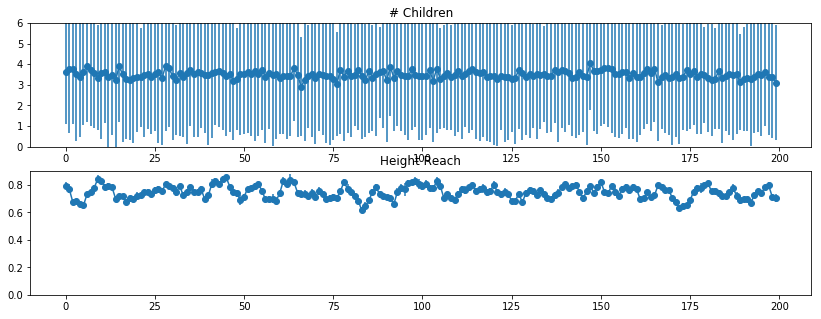

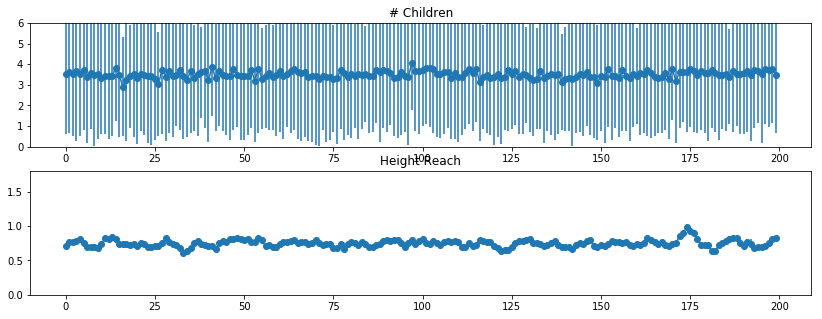

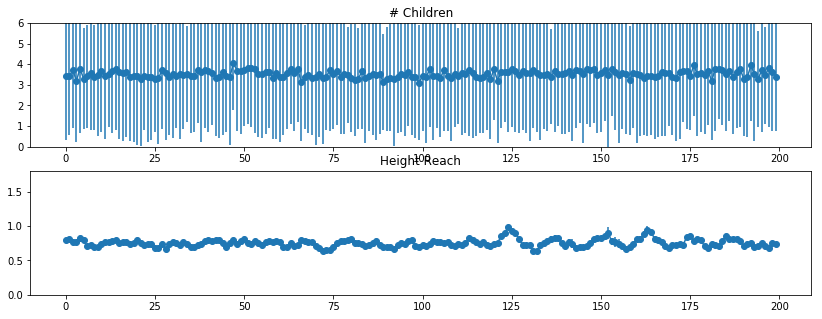

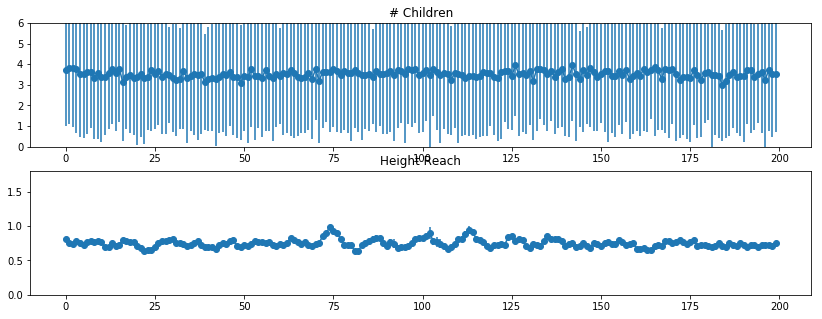

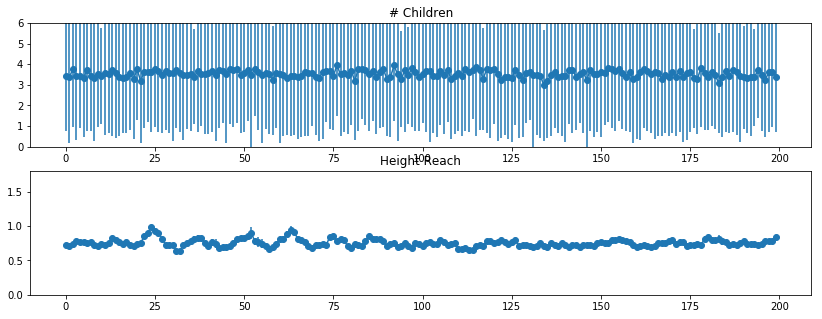

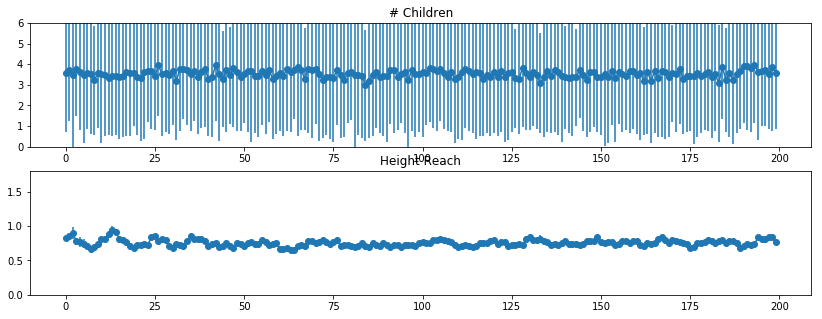

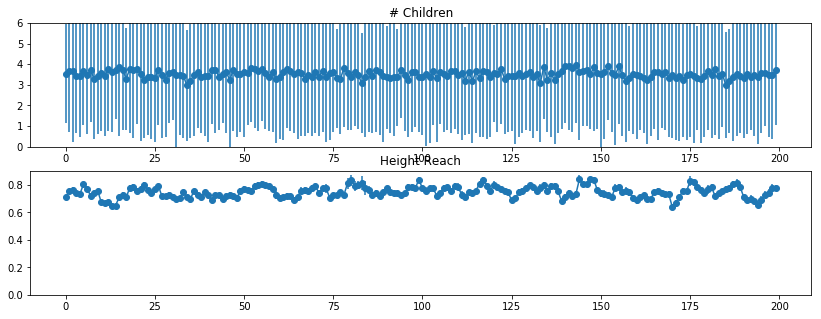

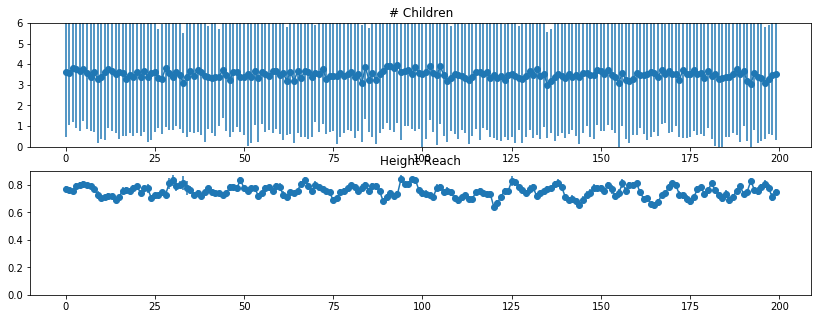

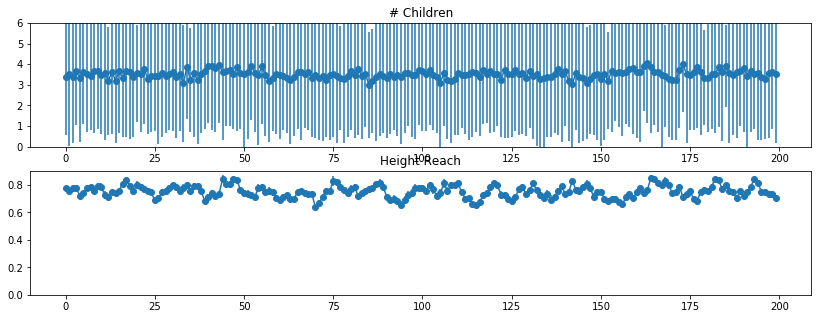

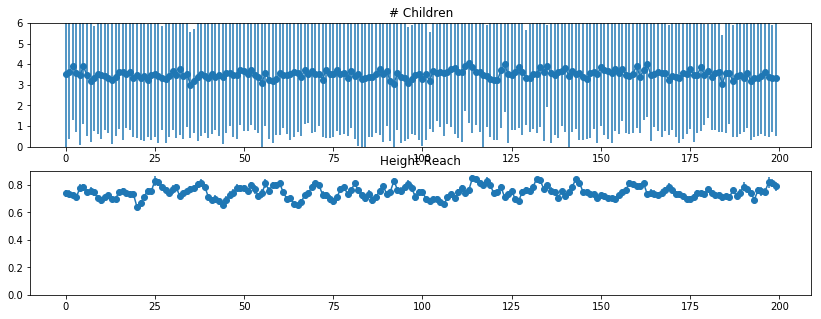

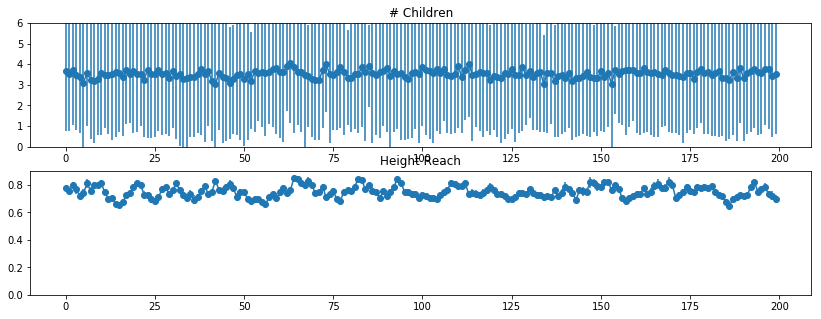

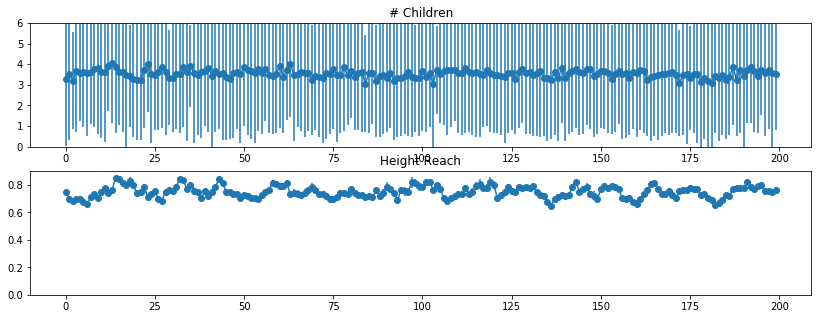

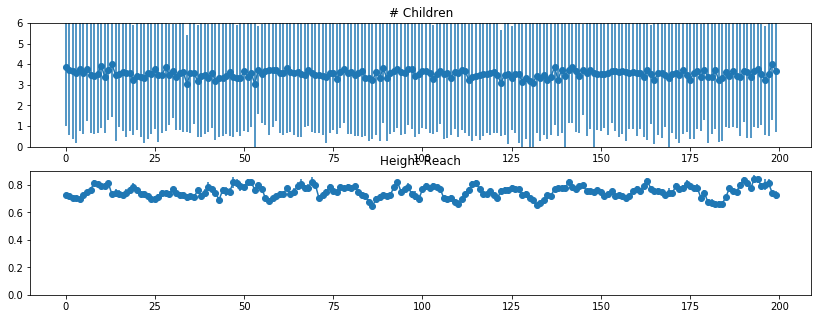

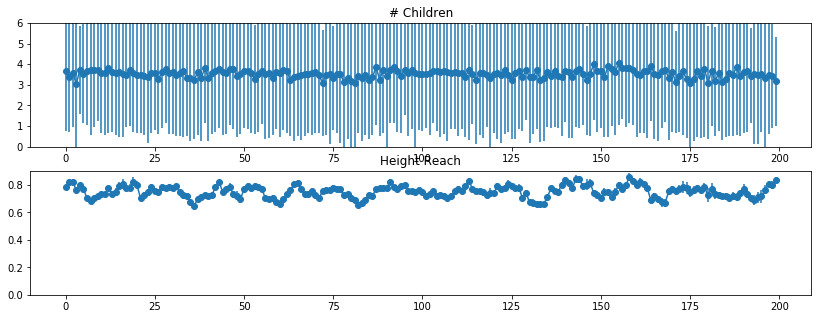

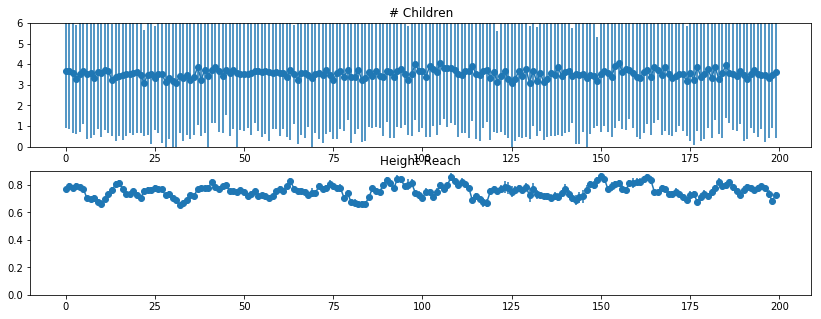

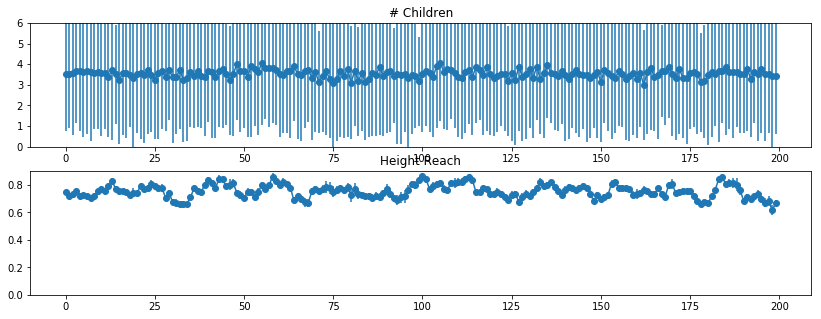

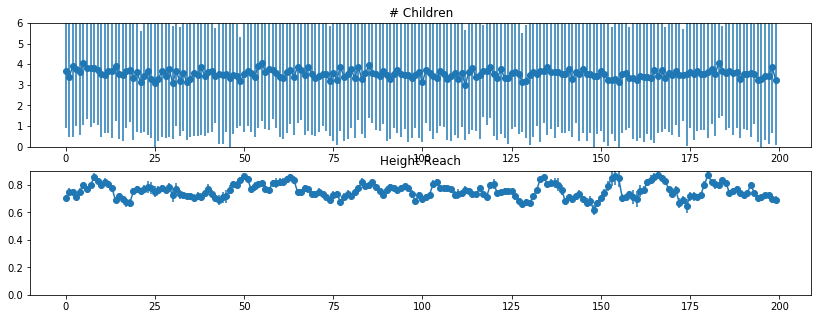

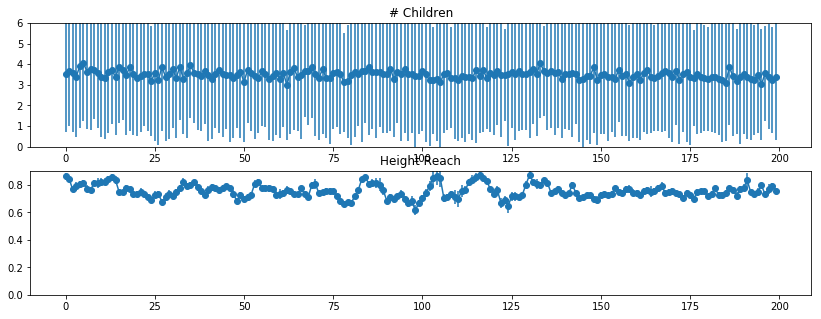

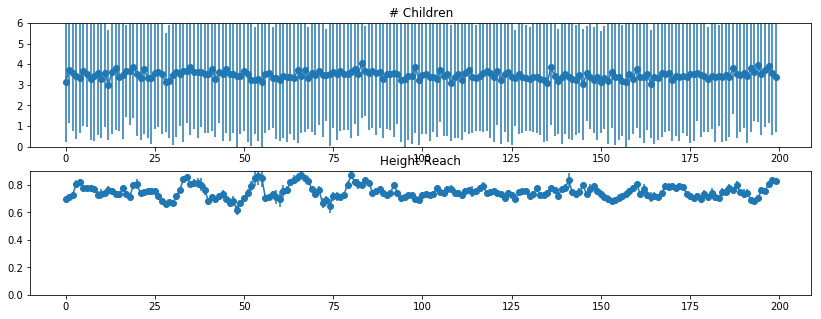

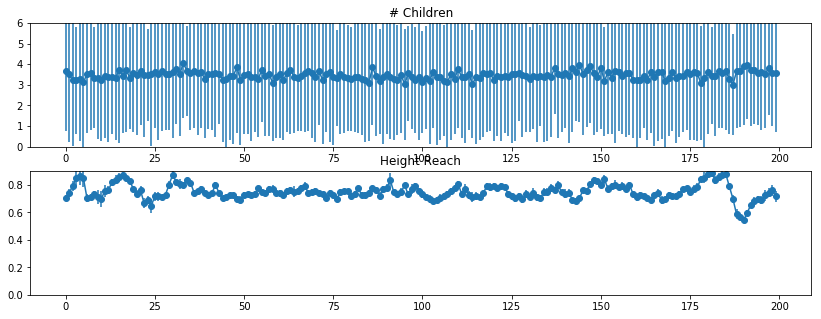

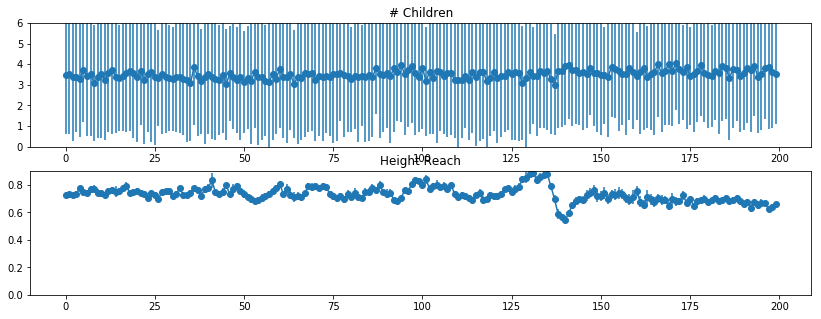

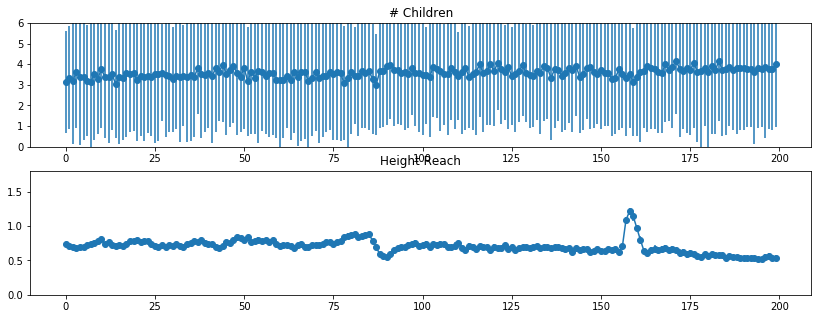

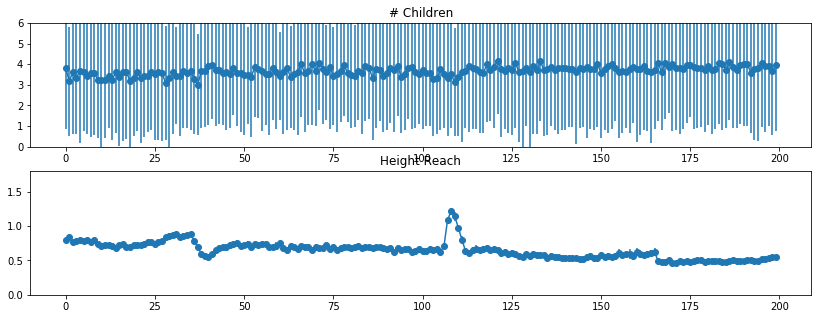

In [14]:
history=[]
n_iters = 500 * 1000

start=90000
for iter in range(start, n_iters + 1):
    spawn.train()
    discrim.train()
    
    discrim_opt.zero_grad()

    real_samples = get_samples(bhalf, concat=True, device=device)
    real_samples = torch.stack([stack[1] for stack in real_samples]).to(device)
    just_bases = get_samples(bhalf, baseonly=True, device=device)
    fake_samples = []
    for stack in just_bases:
        zvar = spawn.init_noise(size=ZSIZE).to(device)
        hp = stack[0]
        hchildren = spawn(hp, zvar, concat=True)
        fake_samples.append(hchildren.squeeze())
    fake_samples = torch.stack(fake_samples).to(device)

    # -- Discrimination Training --
    real_guesses = discrim(real_samples, sigmoid=False)
    fake_guesses = discrim(fake_samples.detach(), sigmoid=False)
    # loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))
    discrim_loss = -torch.mean(real_guesses) + torch.mean(fake_guesses)
    discrim_loss.backward()
    discrim_opt.step()
    for p in discrim.parameters():
        p.data.clamp_(-0.01, 0.01)
    
    real_score = score(real_guesses, real_labels)
    fake_score = score(fake_guesses, fake_labels)
    disc_score = (real_score + fake_score) / 2
    assert disc_score <= 1.0
    
    if iter % 5 == 0:
        fake_samples = []
        just_bases = get_samples(bhalf, baseonly=True, device=device)
        for stack in just_bases:
            zvar = spawn.init_noise(size=ZSIZE).to(device)
            hp = stack[0]
            hchild = spawn(hp, zvar)
            fake_samples.append(hchild.squeeze())
        fake_samples = torch.stack(fake_samples).to(device)
        
        # -- Generator Training --
        gen_opt.zero_grad()
        # loss_G = -torch.mean(discriminator(gen_imgs))
        gen_loss = -torch.mean(discrim(fake_samples, sigmoid=False))
        gen_loss.backward()
        gen_opt.step()

    if iter % 10 == 0:
        sys.stdout.write('[%d] Generate/L: %.5f  Discrim/L : %.5f  Score: %.2f   \r' % (
            iter,
            gen_loss.item(),
            discrim_loss.item(),
            disc_score))
    
    if iter % 100 == 0:
        spawn.eval()
        discrim.eval()
        preview = sample_fakes()
        history.append(preview)

    if iter % 5000 == 0:        
        plot_distrib(history, recent=200)


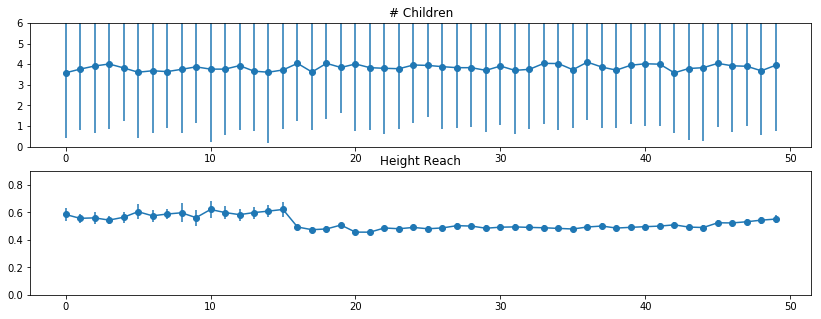

In [15]:
# plot_distrib(history, recent=100)
plot_distrib(history, recent=50)

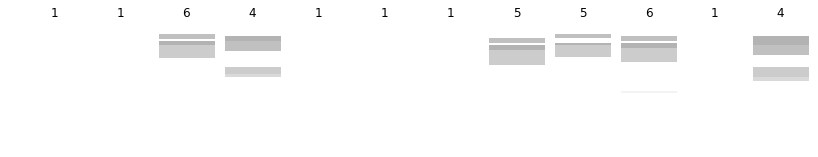

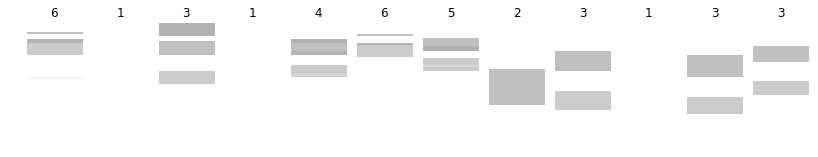

In [29]:
raster_list(history[-1], limit=12, width=32)
raster_list(history[-2], limit=12, width=32)